<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load" data-toc-modified-id="Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Datetime-features" data-toc-modified-id="Datetime-features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Datetime features</a></span></li><li><span><a href="#Click-&amp;-download-stats" data-toc-modified-id="Click-&amp;-download-stats-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Click &amp; download stats</a></span></li><li><span><a href="#Find-recurring-ip,-os,-device,-etc,-and-set-non-recurring-ones-to-0-(meaning-'other')" data-toc-modified-id="Find-recurring-ip,-os,-device,-etc,-and-set-non-recurring-ones-to-0-(meaning-'other')-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Find recurring <code>ip</code>, <code>os</code>, <code>device</code>, etc, and set non-recurring ones to 0 (meaning 'other')</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#One-hot-encode-categorical-features" data-toc-modified-id="One-hot-encode-categorical-features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>One-hot encode categorical features</a></span></li><li><span><a href="#Combine-numeric-and-categorical-(onehot-encoded)-features-to-big-matrices" data-toc-modified-id="Combine-numeric-and-categorical-(onehot-encoded)-features-to-big-matrices-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Combine numeric and categorical (onehot-encoded) features to big matrices</a></span></li></ul></li><li><span><a href="#Save-data-objects" data-toc-modified-id="Save-data-objects-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save data objects</a></span></li></ul></div>

## Load

Packages

In [1]:
# Data tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

# Programming tools
import os
import sys
import gc
from tqdm import tqdm

# Notebook options
%matplotlib inline
pd.set_option('display.max_columns', 0)

Paths

In [64]:
from HERE import *
!type HERE.py

import os

PYTHON_SCRIPTS_DIR = os.path.dirname(os.path.realpath(__file__))
PROJ_ROOT_DIR = os.path.abspath(os.path.join(PYTHON_SCRIPTS_DIR, os.pardir))
SCRATCH_DIR = os.path.join(PROJ_ROOT_DIR, 'scratch')
DOWNLOADS_DIR = os.path.join(PROJ_ROOT_DIR, 'downloads')


Data

In [3]:
%%time
use_train_set = 'train_1Msample'
# available choices for use_train_set: 
#     'train': the full training data set (7.5G csv)
#     'train_sample': a small sample of train, with 100K records
#     'train_1Msample': a random sample of train, with 1M records

train = pd.read_csv(os.path.join(DOWNLOADS_DIR, '{}.csv'.format(use_train_set)))
test = pd.read_csv(os.path.join(DOWNLOADS_DIR, 'test.csv'))

Wall time: 12.8 s


## Feature Engineering

In [4]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (1000000, 8)
test shape: (18790469, 7)


In [5]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,12031,13,1,13,477,2017-11-08 06:13:45,NaN,0
1,24847,12,1,9,178,2017-11-09 11:58:43,NaN,0
2,23102,18,1,19,121,2017-11-08 14:43:57,NaN,0
3,43980,12,1,18,245,2017-11-08 00:02:07,NaN,0
4,122830,1,1,13,115,2017-11-07 05:59:47,NaN,0


In [6]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
ip                 1000000 non-null int64
app                1000000 non-null int64
device             1000000 non-null int64
os                 1000000 non-null int64
channel            1000000 non-null int64
click_time         1000000 non-null object
attributed_time    2498 non-null object
is_attributed      1000000 non-null int64
dtypes: int64(6), object(2)
memory usage: 61.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
click_id      int64
ip            int64
app           int64
device        int64
os            int64
channel       int64
click_time    object
dtypes: int64(6), object(1)
memory usage: 1003.5+ MB


None

Drop the `attributed_time` column of training data, because it is not available in test data.

In [7]:
train.drop(columns=['attributed_time'], inplace=True)

### Datetime features

In [8]:
%%time

def extend_datetime_features(df):
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['click_hour'] = df['click_time'].dt.hour
    df['click_minute'] = df['click_time'].dt.minute
    df['click_second'] = df['click_time'].dt.second
    df['click_minute_mod15'] = df['click_minute'] % 15
    df['click_second_mod5'] = df['click_second'] % 5
    return df

train = extend_datetime_features(train)
test = extend_datetime_features(test)

train.head()

Wall time: 7.21 s


### Click & download stats

Create click & download counts grouped by different features.

In [9]:
%%time
stats_by_ = {}
force_regenerate = False  # force re-calculate stats from current training set. If False, will read these stats from `scratch/` folder
original_features = ['ip', 'app', 'device', 'os', 'channel']

for ft in original_features:
    # For each feature (ip, app, device, etc.) count clicks and downloads grouped by that feature
    # you'll have columns like `clicks_by_ip`, `downloads_by_ip`, `download_ratio_by_ip`, `clicks_by_app`, ...
    csv_file_path = os.path.join(SCRATCH_DIR, 'stats_by_{}.csv'.format(ft))
    if not os.path.exists(csv_file_path) or force_regenerate:
        stats = train.groupby(ft).agg({'is_attributed': ['size', 'sum']})
        stats.columns = stats.columns.droplevel(0)
        cl_colname, dl_colname, ratio_colname = [col+'_by_'+ft for col in ['clicks', 'downloads', 'download_ratio']]
        stats.rename(columns={'size':cl_colname, 'sum':dl_colname}, inplace=True)
        stats[ratio_colname] = stats[dl_colname] / stats[cl_colname]

        # Save the stats to csv file in scrach folder
        stats.to_csv()
        stats_by_[ft] = stats
        gc.collect()
    else:
        stats_by_[ft] = pd.read_csv(csv_file_path).set_index(ft)

Wall time: 204 ms


Define a function that adds by-feature stats to a dataframe.

In [10]:
def add_stats_by_feature(df, stats_by_feature):
    for ft in stats_by_feature.keys():
        if ft not in df.columns:
            print('{} not found in dataframe, no merge happens.'.format(ft))
            continue
        df = df.merge(stats_by_feature[ft], how='left', left_on=ft, right_index=True)
    df.fillna({col: 0 for col in stats_by_feature[ft].columns}, inplace=True)
    return df

Add the stats to `train` data set.  
Caution: The following cell may crash when `train` is too large.

In [11]:
%%time
train = add_stats_by_feature(train, stats_by_)
test = add_stats_by_feature(test, stats_by_)

Wall time: 22.1 s


In [12]:
print('train shape:', train.shape)
display(train.head())

train shape: (1000000, 27)


,ip,app,device,os,channel,click_time,is_attributed,click_hour,click_minute,click_second,click_minute_mod15,click_second_mod5,clicks_by_ip,downloads_by_ip,download_ratio_by_ip,clicks_by_app,downloads_by_app,download_ratio_by_app,clicks_by_device,downloads_by_device,download_ratio_by_device,clicks_by_os,downloads_by_os,download_ratio_by_os,clicks_by_channel,downloads_by_channel,download_ratio_by_channel
0,12031,13,1,13,477,2017-11-08 06:13:45,0,6,13,45,13,0,22523,28,0.001243,4329409,721,0.000167,174330052,306495,0.001758,39782808,61622,0.001549,7188340,1212,0.000169
1,24847,12,1,9,178,2017-11-09 11:58:43,0,11,58,43,13,3,33597,22,0.000655,24179003,2640,0.000109,174330052,306495,0.001758,4370878,3189,0.000730,5271408,627,0.000119
2,23102,18,1,19,121,2017-11-08 14:43:57,0,14,43,57,13,2,13917,14,0.001006,15756587,7919,0.000503,174330052,306495,0.001758,44181914,79669,0.001803,4692438,2055,0.000438
3,43980,12,1,18,245,2017-11-08 00:02:07,0,0,2,7,2,2,2049,4,0.001952,24179003,2640,0.000109,174330052,306495,0.001758,8974159,11682,0.001302,8873025,829,0.000093
4,122830,1,1,13,115,2017-11-07 05:59:47,0,5,59,47,14,2,6888,11,0.001597,5796274,1230,0.000212,174330052,306495,0.001758,39782808,61622,0.001549,1384504,196,0.000142


### Find recurring `ip`, `os`, `device`, etc, and set non-recurring ones to 0 (meaning 'other')
"Recurring" IPs are those who had more than 1 downlad

This makes one-hot encoding easier.

In [13]:
recurring_ = {}
for ft in original_features:
    is_recurring = stats_by_[ft]['downloads_by_'+ft]>1
    recurring_[ft] = set(stats_by_[ft].index[is_recurring].tolist())
    print(len(recurring_[ft]), 'recurring', ft)

49606 recurring ip
187 recurring app
1126 recurring device
103 recurring os
164 recurring channel


In [14]:
%%time
for ft in original_features:
    train[ft] = train[ft].apply(lambda x: x if x in recurring_[ft] else 0)

Wall time: 1.63 s


## Preprocessing

In [15]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed,click_hour,click_minute,click_second,click_minute_mod15,click_second_mod5,clicks_by_ip,downloads_by_ip,download_ratio_by_ip,clicks_by_app,downloads_by_app,download_ratio_by_app,clicks_by_device,downloads_by_device,download_ratio_by_device,clicks_by_os,downloads_by_os,download_ratio_by_os,clicks_by_channel,downloads_by_channel,download_ratio_by_channel
0,12031,13,1,13,477,2017-11-08 06:13:45,0,6,13,45,13,0,22523,28,0.001243,4329409,721,0.000167,174330052,306495,0.001758,39782808,61622,0.001549,7188340,1212,0.000169
1,24847,12,1,9,178,2017-11-09 11:58:43,0,11,58,43,13,3,33597,22,0.000655,24179003,2640,0.000109,174330052,306495,0.001758,4370878,3189,0.000730,5271408,627,0.000119
2,23102,18,1,19,121,2017-11-08 14:43:57,0,14,43,57,13,2,13917,14,0.001006,15756587,7919,0.000503,174330052,306495,0.001758,44181914,79669,0.001803,4692438,2055,0.000438
3,43980,12,1,18,245,2017-11-08 00:02:07,0,0,2,7,2,2,2049,4,0.001952,24179003,2640,0.000109,174330052,306495,0.001758,8974159,11682,0.001302,8873025,829,0.000093
4,122830,1,1,13,115,2017-11-07 05:59:47,0,5,59,47,14,2,6888,11,0.001597,5796274,1230,0.000212,174330052,306495,0.001758,39782808,61622,0.001549,1384504,196,0.000142


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 27 columns):
ip                           1000000 non-null int64
app                          1000000 non-null int64
device                       1000000 non-null int64
os                           1000000 non-null int64
channel                      1000000 non-null int64
click_time                   1000000 non-null datetime64[ns]
is_attributed                1000000 non-null int64
click_hour                   1000000 non-null int64
click_minute                 1000000 non-null int64
click_second                 1000000 non-null int64
click_minute_mod15           1000000 non-null int64
click_second_mod5            1000000 non-null int64
clicks_by_ip                 1000000 non-null int64
downloads_by_ip              1000000 non-null int64
download_ratio_by_ip         1000000 non-null float64
clicks_by_app                1000000 non-null int64
downloads_by_app             1000000 non-null

In [17]:
print(list(train.columns))

['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed', 'click_hour', 'click_minute', 'click_second', 'click_minute_mod15', 'click_second_mod5', 'clicks_by_ip', 'downloads_by_ip', 'download_ratio_by_ip', 'clicks_by_app', 'downloads_by_app', 'download_ratio_by_app', 'clicks_by_device', 'downloads_by_device', 'download_ratio_by_device', 'clicks_by_os', 'downloads_by_os', 'download_ratio_by_os', 'clicks_by_channel', 'downloads_by_channel', 'download_ratio_by_channel']


In [18]:
cat_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_minute_mod15', 'click_second_mod5']
num_cols = ['click_hour', 'click_minute', 'click_second', 
            'clicks_by_ip', 'downloads_by_ip', 'download_ratio_by_ip', 
            'clicks_by_app', 'downloads_by_app', 'download_ratio_by_app', 
            'clicks_by_device', 'downloads_by_device', 'download_ratio_by_device', 
            'clicks_by_os', 'downloads_by_os', 'download_ratio_by_os', 
            'clicks_by_channel', 'downloads_by_channel', 'download_ratio_by_channel']
target_col = 'is_attributed'

### One-hot encode categorical features

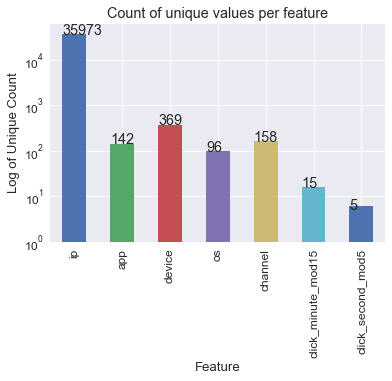

In [19]:
from helper.plotting import plot_df_nunique
plot_df_nunique(train, cat_cols, log_scale=True)

[`label_binarize`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html#sklearn.preprocessing.label_binarize) is good for
> transformation for a fixed set of class labels known ahead of time

In [20]:
from sklearn.preprocessing import label_binarize
from scipy import sparse

train_onehot_ = {}
test_onehot_ = {}

for ft in cat_cols:
    print('One-hot encode:', ft)
    train_onehot_[ft] = label_binarize(train[ft], 
                                       classes=list(recurring_.get(ft) or np.sort(train[ft].unique())), 
                                       sparse_output=True
                                      )
    test_onehot_[ft] = label_binarize(test[ft],
                                      classes=list(recurring_.get(ft) or np.sort(test[ft].unique())),
                                      sparse_output=True
                                     )

train_onehot = sparse.hstack([train_onehot_[col] for col in cat_cols])
test_onehot = sparse.hstack([test_onehot_[col] for col in cat_cols])

One-hot encode: ip
One-hot encode: app
One-hot encode: device
One-hot encode: os
One-hot encode: channel
One-hot encode: click_minute_mod15
One-hot encode: click_second_mod5


### Combine numeric and categorical (onehot-encoded) features to big matrices

In [21]:
%%time
X_train = sparse.hstack((train[num_cols], train_onehot))
y_train = train[target_col].values

try:
    del train
except:
    pass

try:
    del train_onehot
except:
    pass

gc.collect()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (1000000, 51224)
y_train shape: (1000000,)
Wall time: 1.23 s


In [22]:
%%time
X_test = sparse.hstack((test[num_cols], test_onehot))

try:
    del test
except:
    pass

try:
    del test_onehot
except:
    pass

gc.collect()

print('X_test shape:', X_test.shape)

X_test shape: (18790469, 51224)
Wall time: 44.2 s


## Save data objects

In [23]:
display(type(X_train))
display(type(y_train))
display(type(X_test))

scipy.sparse.coo.coo_matrix

numpy.ndarray

scipy.sparse.coo.coo_matrix

In [25]:
%%time
if not os.path.exists(os.path.join(SCRATCH_DIR, use_train_set)):
    os.makedirs(os.path.join(SCRATCH_DIR, use_train_set))
    
sparse.save_npz(os.path.join(SCRATCH_DIR, use_train_set,'X_train.npz'), X_train)
np.save(os.path.join(SCRATCH_DIR, use_train_set, 'y_train.npy'), y_train)
sparse.save_npz(os.path.join(SCRATCH_DIR, 'X_test.npz'), X_test)

Wall time: 2min 38s
